# Modelamiento con sitios CpG

## Librerías y path

In [1]:
import sys
from pathlib import Path
import os

src_path = str(Path.cwd().parents[0] / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

raw_path = str(Path.cwd().parents[0] / "data" / "raw")
preprocess_path = str(Path.cwd().parents[0] / "data" / "preprocessed")


In [2]:
import seaborn as sns    
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(42)

## Lectura y preprocesamiento básico

In [4]:
df_gdc = pd.read_csv(f'{preprocess_path}/cpg_preprocessed.csv')

In [5]:
# Pasar a años (Posiblemente redundante, por el uso de minmax(?) )
df_gdc['age'] = df_gdc['age']/365.25
# Escalado
df_gdc['age'] = MinMaxScaler().fit_transform(df_gdc[['age']])

In [6]:
features_to_drop = ['file_id', 'size', 'disease', 'race', 'etnia', 'sample_type']
x, y = df_gdc.drop(columns = features_to_drop), df_gdc['sample_type'].replace({'Primary Tumor':1, 'Solid Tissue Normal':0})

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=42)

## Definición de pipelines

Métodos de selección:
- SVM (lineal)
- ANOVA + RF
- RF iterativo

Métodos de clasificación:
- Red feedforward
- RF, XGB
- SVM (RBF)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from imblearn.pipeline import Pipeline
from gene_preprocessing import SelectByIterRF, SelectByPValue
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [9]:
anova_fs = [
    ('Percentile Best', SelectPercentile(f_classif, percentile=85)),
    ('P-Value', SelectByPValue()),
    ('Select RF', SelectFromModel(RandomForestClassifier(random_state=42)))
]
sv_fs = [('Select SVM', SelectFromModel(SVC(kernel = 'linear', random_state=42)))]
iter_rf_fs = [('Select RF',SelectByIterRF(thresh=0.99, pos_label=1))]


In [10]:
def fs_pipeline(fs):
    return Pipeline(
        fs
    )

## Clasificación

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from modeling_utils import bar_metrics, fit_estimators_from_dict, predict_from_dict
from modeling_utils import create_dataloaders, simple_binary_train, NeuralNetwork, train_plot
import torch

basic_estimators = {'SVM': SVC(kernel='rbf', random_state=42),
                      'RF':RandomForestClassifier(random_state=42),
                       'XGB': XGBClassifier(random_state=42)}

### Selección con Anova

In [12]:
anova_pipe = fs_pipeline(anova_fs)
anova_pipe.set_output(transform="pandas")
x_anova = anova_pipe.fit_transform(x_train, y_train)
anova_test = anova_pipe.transform(x_test)

x_anova, y_anova = SMOTE().fit_resample(x_anova, y_train)

x_anova.shape

(498, 196)

#### Clasificadores tradicionales

In [13]:
anova_estimators = fit_estimators_from_dict(x_anova, y_anova, basic_estimators)

In [14]:
anova_pred_test = predict_from_dict(anova_test, anova_estimators)

#### Red neuronal

In [15]:
x_anova_train, x_anova_val, y_anova_train, y_anova_val = train_test_split(x_anova, y_anova, train_size=0.8, stratify=y_anova, random_state=42)
train_anova_loader, val_anova_loader = create_dataloaders(x_anova_train.values, y_anova_train.values,
 x_anova_val.values, y_anova_val.values)

Epoch: 1/50, Train Loss: 0.6941, Val Loss: 0.6917
Epoch: 11/50, Train Loss: 0.0681, Val Loss: 0.0270
Epoch: 21/50, Train Loss: 0.0303, Val Loss: 0.0012
Epoch: 31/50, Train Loss: 0.0101, Val Loss: 0.0090
Epoch: 41/50, Train Loss: 0.0160, Val Loss: 0.0150


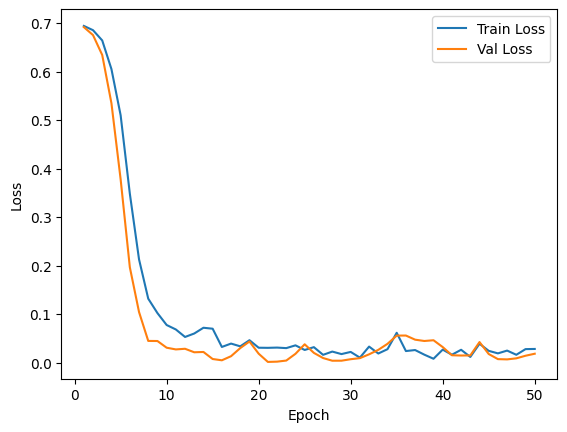

In [16]:
ff_anova = NeuralNetwork(in_features = x_anova_train.shape[1])
anova_train_loss, anova_val_loss = simple_binary_train(ff_anova, train_anova_loader, val_anova_loader)
train_plot(anova_train_loss, anova_val_loss)

#### Métricas

In [17]:
anova_pred_test['Red FF'] = ff_anova.predict( torch.tensor(anova_test.values, dtype=torch.float32))

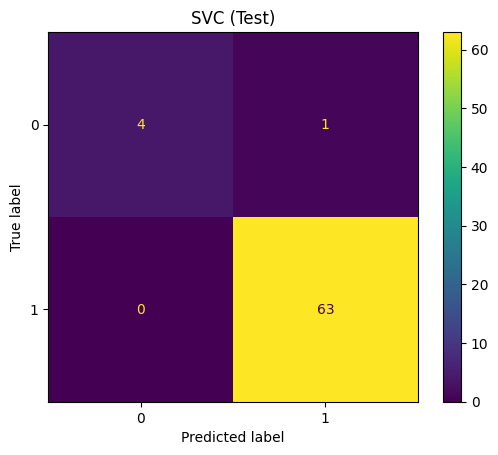

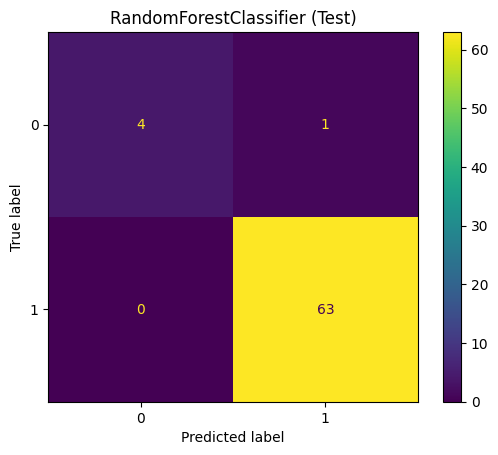

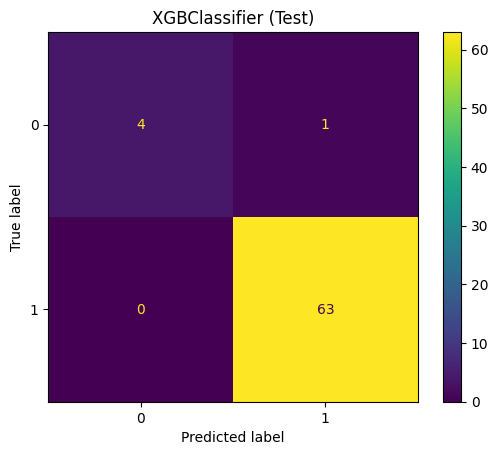

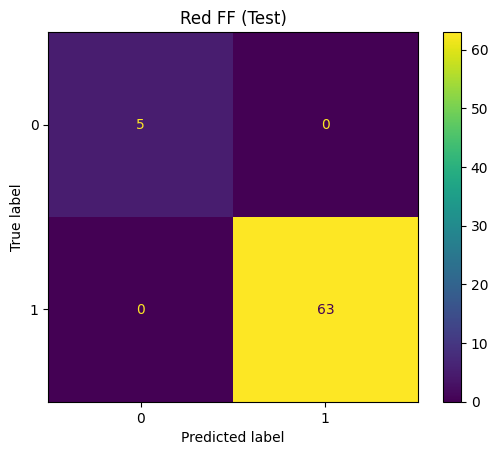

In [18]:
for estim in anova_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, anova_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

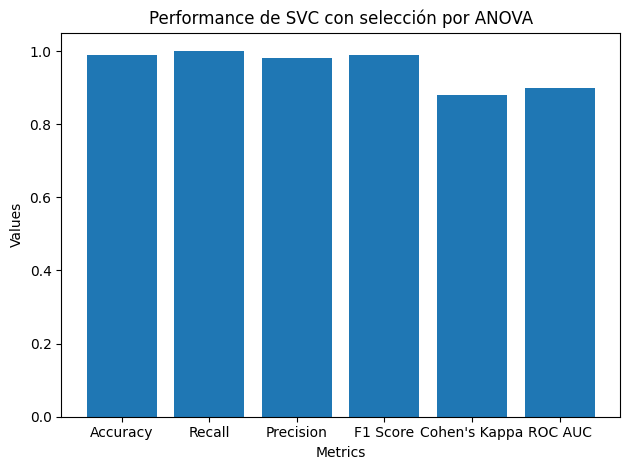

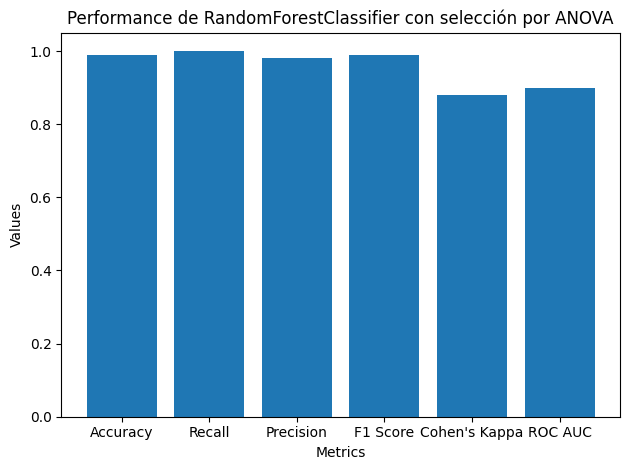

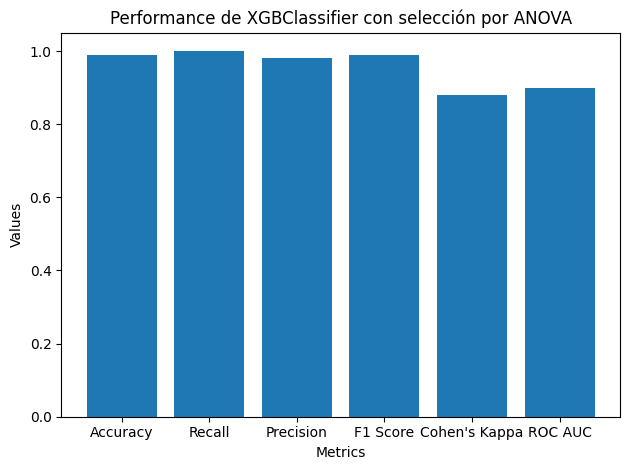

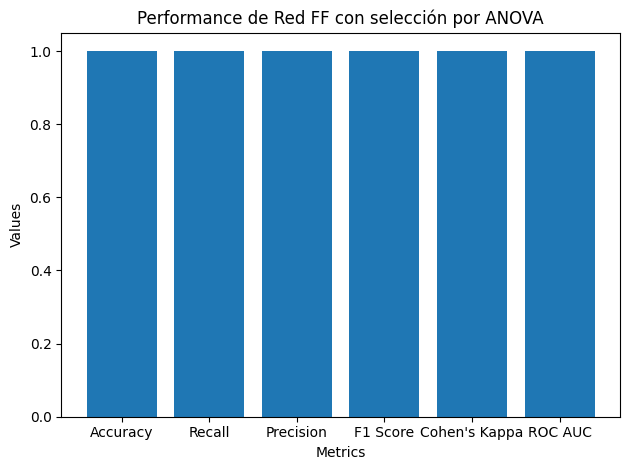

In [19]:
for estim in anova_pred_test:
    bar_metrics(y_test, anova_pred_test[estim], f"Performance de {estim} con selección por ANOVA")

### Selección con SVM

In [20]:
svm_pipe = fs_pipeline(sv_fs)
svm_pipe.set_output(transform="pandas")
x_svm = svm_pipe.fit_transform(x_train, y_train)
svm_test = svm_pipe.transform(x_test)

x_svm, y_svm = SMOTE().fit_resample(x_svm, y_train)
x_svm.shape

(498, 5122)

#### Estimadores tradicionales

In [21]:
svm_estimators = fit_estimators_from_dict(x_svm, y_svm, basic_estimators)

In [22]:
svm_pred_test = predict_from_dict(svm_test, svm_estimators)

#### Red FF

In [23]:
x_svm_train, x_svm_val, y_svm_train, y_svm_val = train_test_split(
    x_svm, y_svm, train_size=0.8, stratify=y_svm, random_state=42)

train_svm_loader, val_svm_loader = create_dataloaders(x_svm_train.values, y_svm_train.values,
                                                                       x_svm_val.values, y_svm_val.values)


Epoch: 1/50, Train Loss: 0.7028, Val Loss: 0.6848
Epoch: 11/50, Train Loss: 0.0878, Val Loss: 0.0452
Epoch: 21/50, Train Loss: 0.0718, Val Loss: 0.0414
Epoch: 31/50, Train Loss: 0.0651, Val Loss: 0.0023
Epoch: 41/50, Train Loss: 0.0747, Val Loss: 0.0992


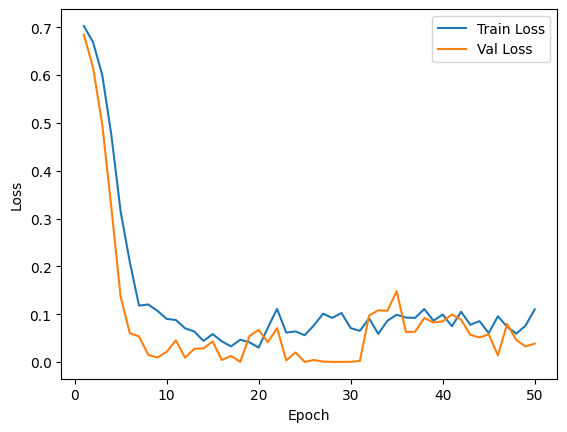

In [24]:
ff_svm = NeuralNetwork(in_features = x_svm_train.shape[1])
svm_train_loss, svm_val_loss = simple_binary_train(ff_svm, train_svm_loader, val_svm_loader)
train_plot(svm_train_loss, svm_val_loss)

#### Métricas

In [25]:
svm_pred_test['Red FF'] = ff_svm.predict(torch.tensor(
    svm_test.values, dtype=torch.float32))

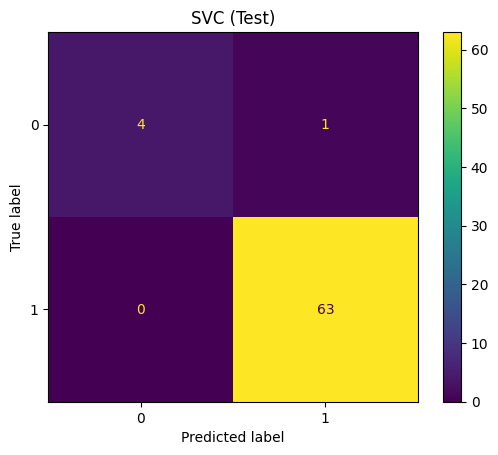

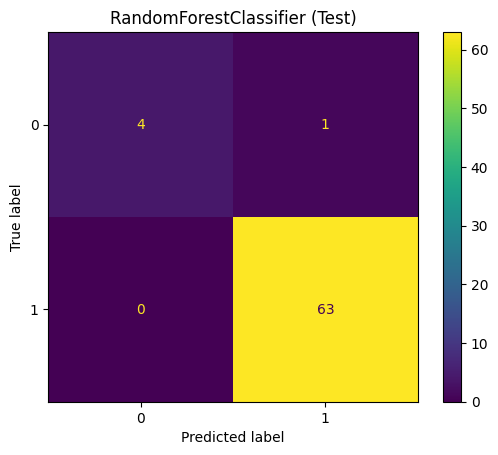

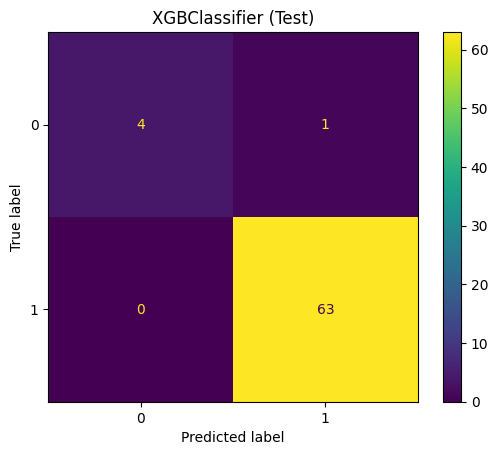

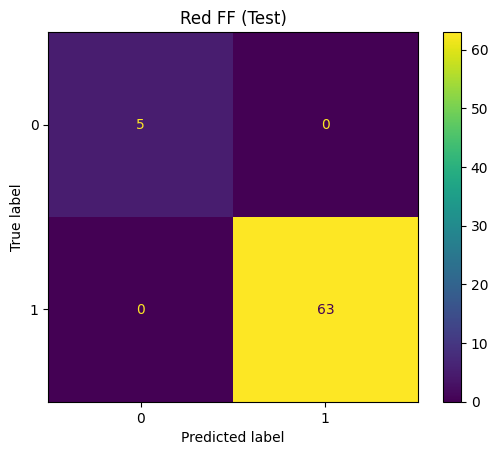

In [26]:
for estim in svm_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, svm_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

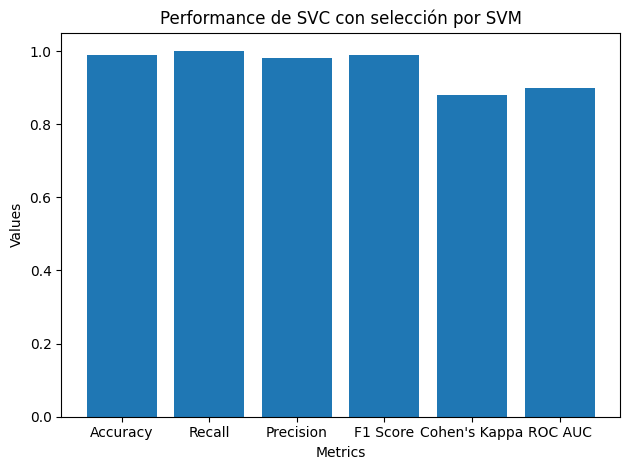

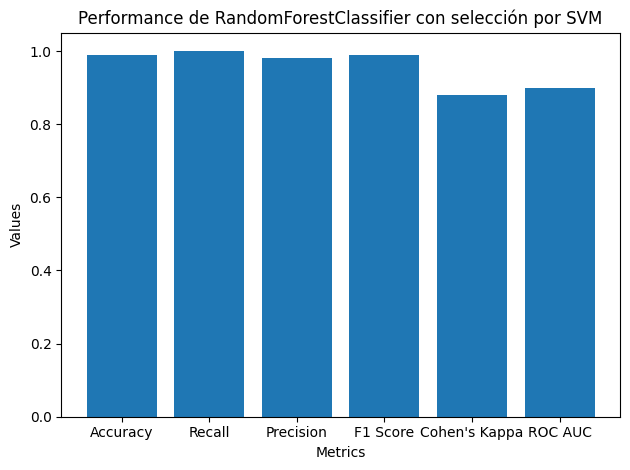

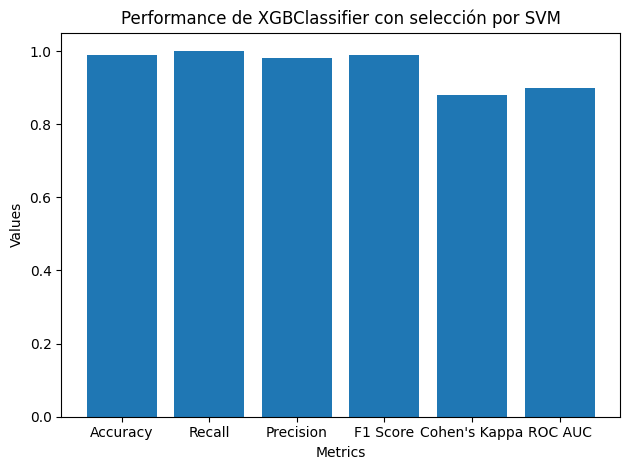

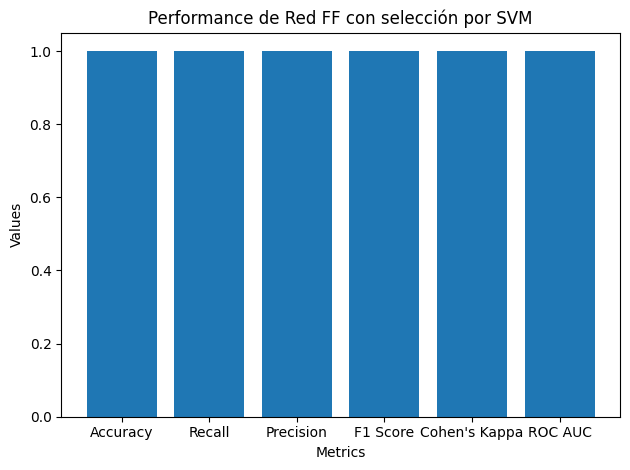

In [27]:
for estim in svm_pred_test:
    bar_metrics(y_test, svm_pred_test[estim], f"Performance de {estim} con selección por SVM")

### Selección con Random Forest iterativo

In [28]:
rf_pipe = fs_pipeline(iter_rf_fs)
rf_pipe.set_output(transform="pandas")
x_rf = rf_pipe.fit_transform(x_train, y_train)
rf_test = rf_pipe.transform(x_test)

x_rf, y_rf = SMOTE().fit_resample(x_rf, y_train)
x_rf.shape

(498, 2713)

#### Estimadores tradicionales

In [29]:
rf_estimators = fit_estimators_from_dict(x_rf, y_rf, basic_estimators)

#### Red FF

In [30]:
x_rf_train, x_rf_val, y_rf_train, y_rf_val = train_test_split(
    x_rf, y_rf, train_size=0.8, stratify=y_rf, random_state=42)

train_rf_loader, val_rf_loader = create_dataloaders(x_rf_train.values, y_rf_train.values,
                                                                       x_rf_val.values, y_rf_val.values)


Epoch: 1/50, Train Loss: 0.6940, Val Loss: 0.6835
Epoch: 11/50, Train Loss: 0.2264, Val Loss: 0.1676
Epoch: 21/50, Train Loss: 0.1680, Val Loss: 0.0416
Epoch: 31/50, Train Loss: 0.1223, Val Loss: 0.0339
Epoch: 41/50, Train Loss: 0.1477, Val Loss: 0.0273


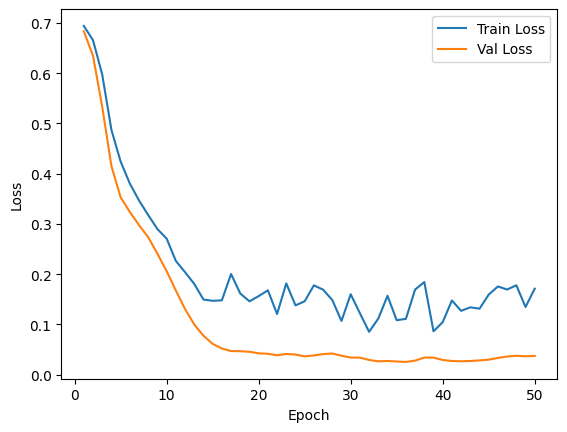

In [31]:
ff_rf = NeuralNetwork(in_features = x_rf_train.shape[1])
rf_train_loss, rf_val_loss = simple_binary_train(ff_rf, train_rf_loader, val_rf_loader)
train_plot(rf_train_loss, rf_val_loss)

### Métricas

In [32]:
rf_pred_test = predict_from_dict(rf_test, rf_estimators)
rf_pred_test['Red FF'] = ff_rf.predict(torch.tensor(
    rf_test.values, dtype=torch.float32))

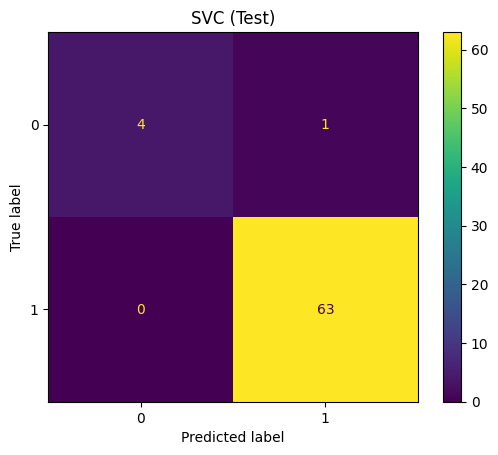

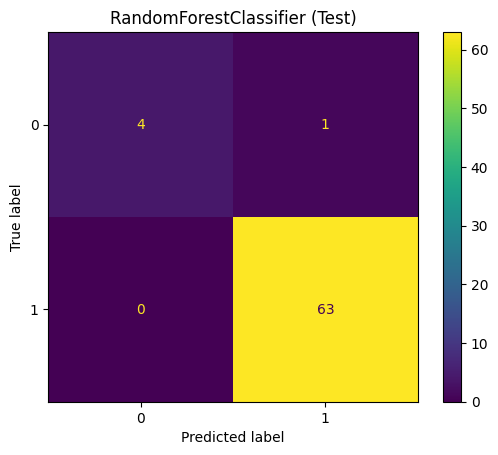

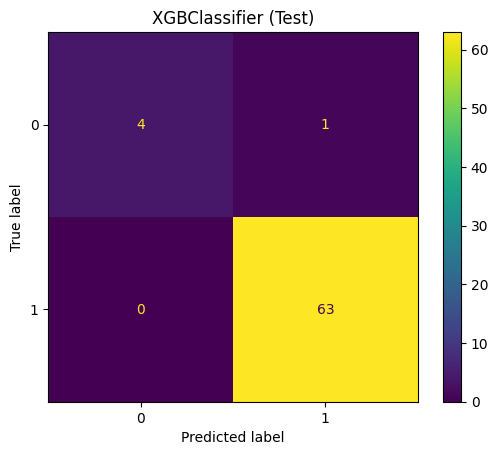

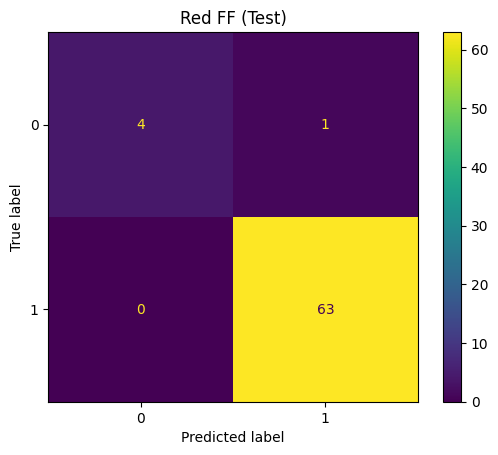

In [33]:
for estim in rf_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

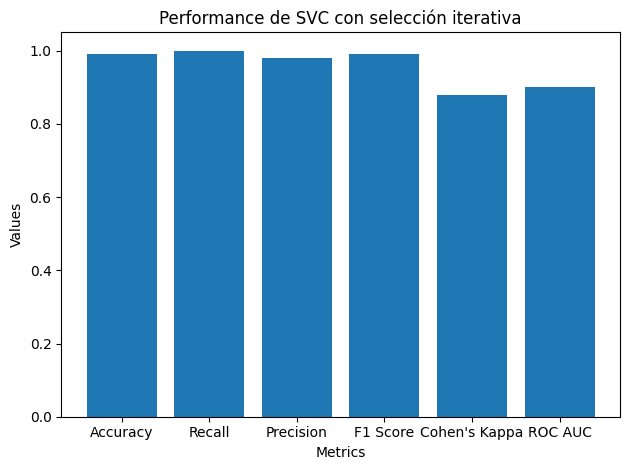

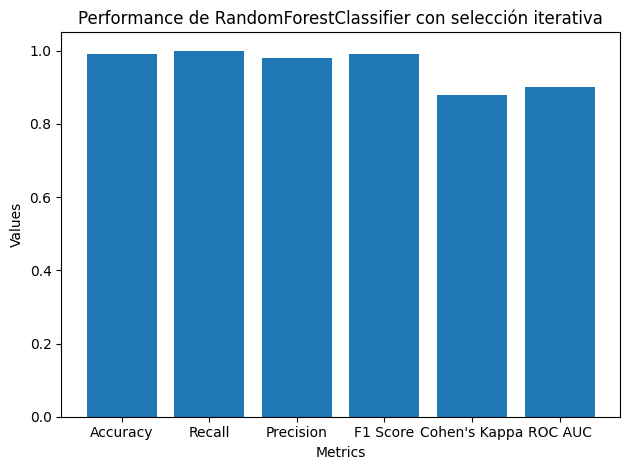

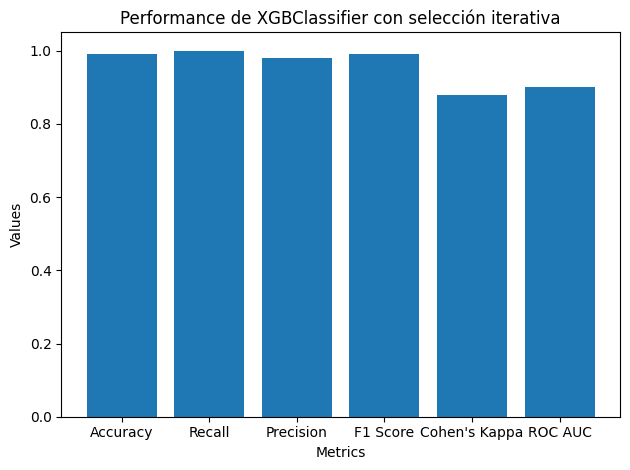

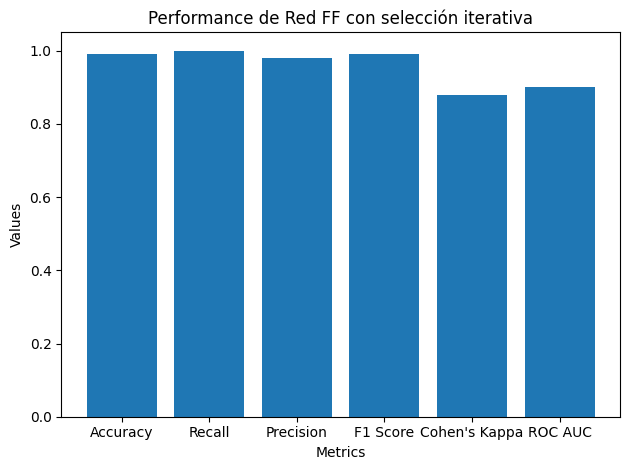

In [34]:
for estim in rf_pred_test:
    bar_metrics(y_test, rf_pred_test[estim], f"Performance de {estim} con selección iterativa")

## Interpretabilidad

Nota: No se calculan shap values en el caso de SVM, debido al coste computacional que involucra

In [35]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Selección por RF

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


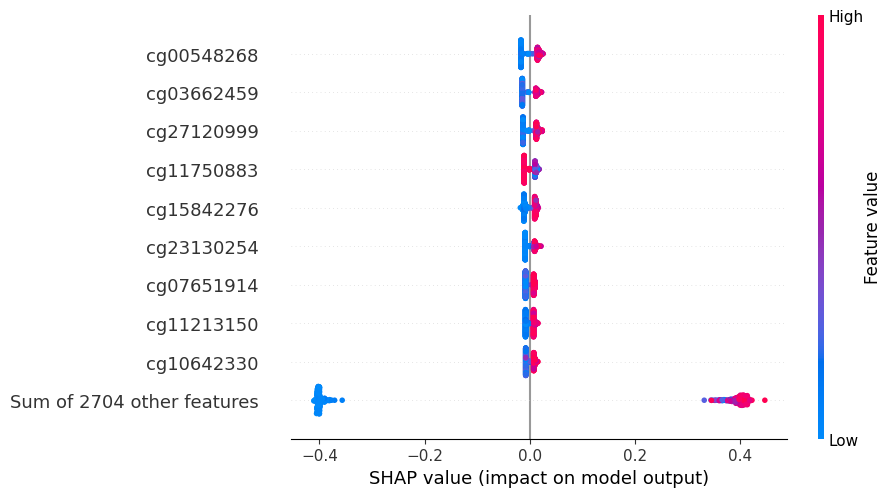

In [36]:
rf_rf = rf_estimators['RandomForestClassifier']
explainer = shap.Explainer(rf_rf, x_rf)
shap_values = explainer(x_rf)
shap.plots.beeswarm(shap_values[:,:,1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


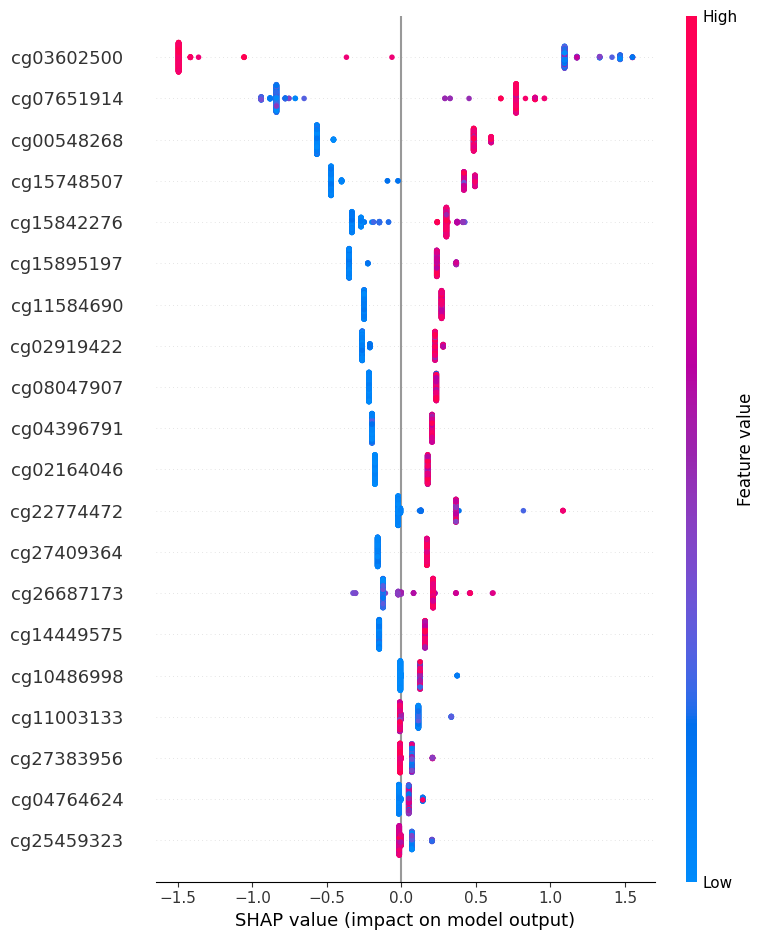

In [37]:
xgb_rf = rf_estimators['XGBClassifier']

explainer = shap.TreeExplainer(xgb_rf)
shap_values = explainer(x_rf)
shap.summary_plot(shap_values, x_rf)

### Selección por ANOVA

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


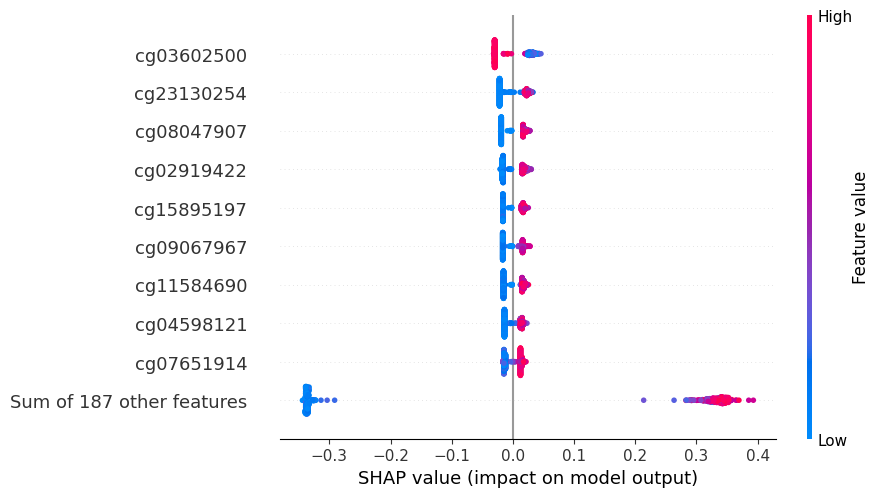

In [38]:
rf_anova = anova_estimators['RandomForestClassifier']
explainer = shap.Explainer(rf_anova, x_anova)
shap_values = explainer(x_anova)
shap.plots.beeswarm(shap_values[:,:,1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


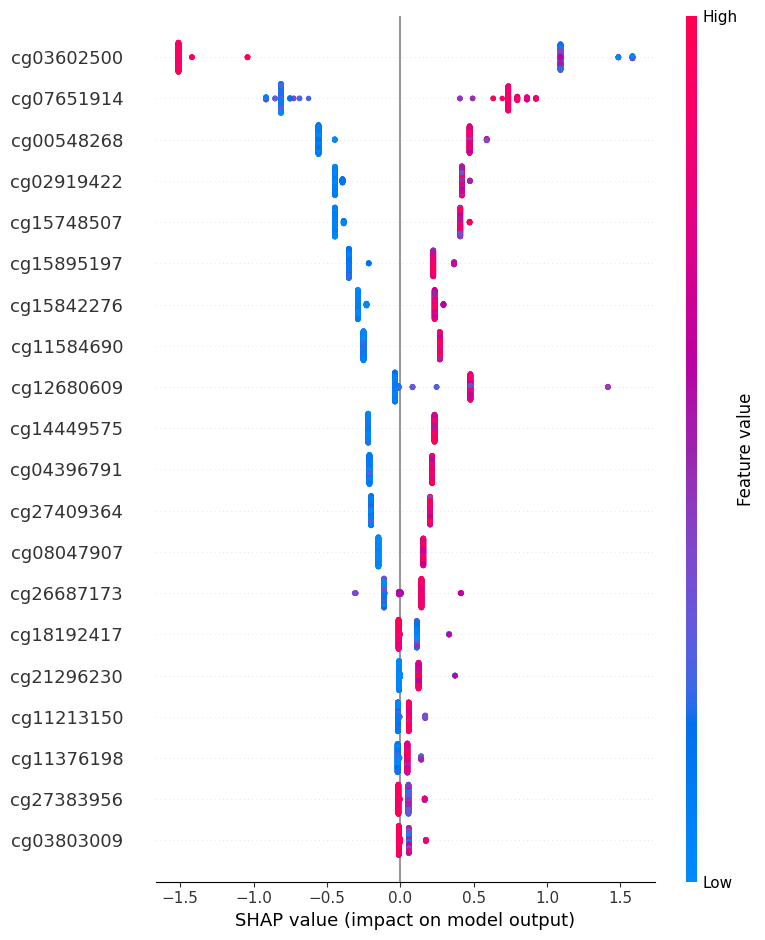

In [39]:
xgb_anova = anova_estimators['XGBClassifier']

explainer = shap.TreeExplainer(xgb_anova)
shap_values = explainer(x_anova)
shap.summary_plot(shap_values, x_anova)

### Selección por SVM

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


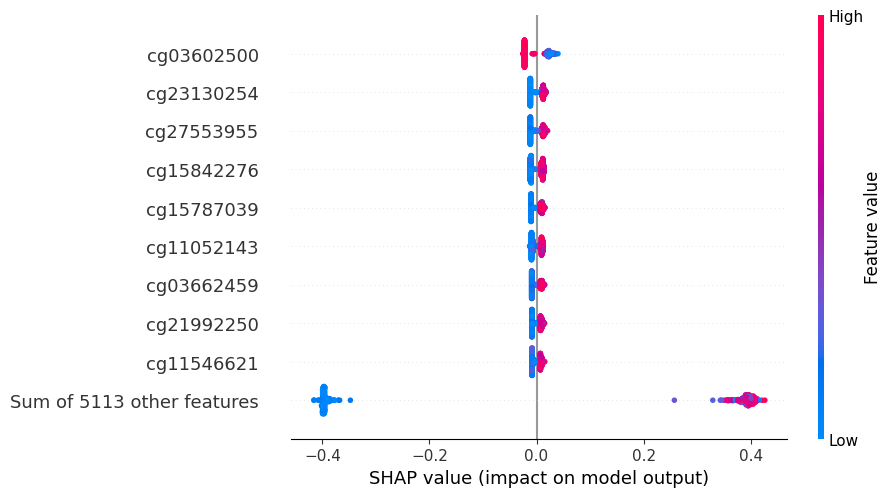

In [40]:
rf_svm = svm_estimators['RandomForestClassifier']
explainer = shap.Explainer(rf_svm, x_svm)
shap_values = explainer(x_svm)
shap.plots.beeswarm(shap_values[:,:,1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


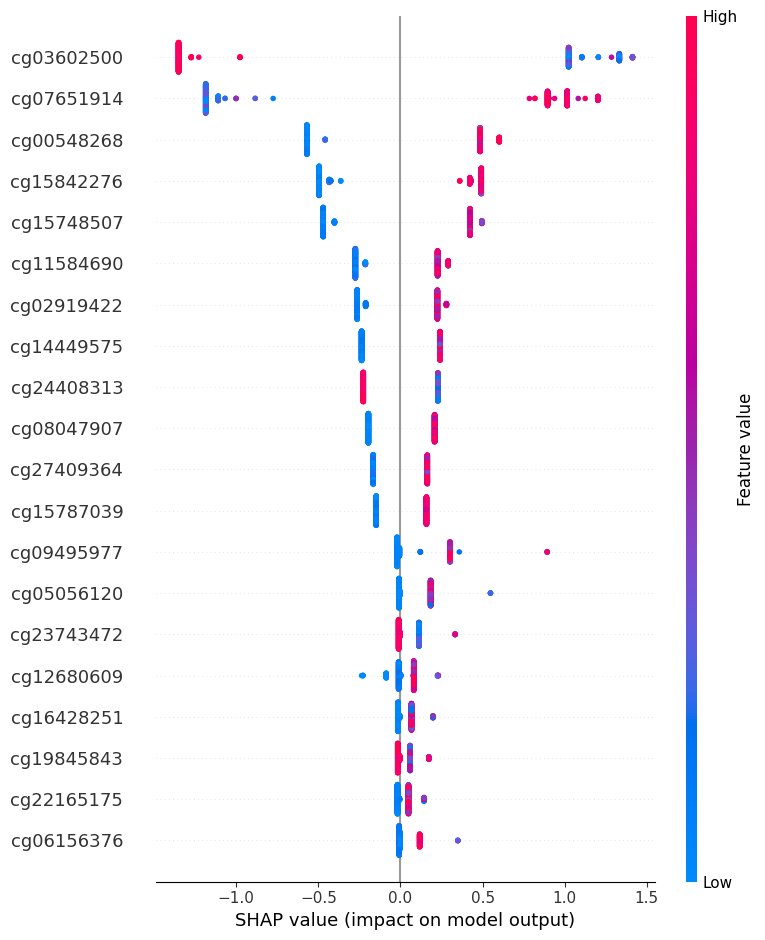

In [41]:
xgb_svm = svm_estimators['XGBClassifier']

explainer = shap.TreeExplainer(xgb_svm)
shap_values = explainer(x_svm)
shap.summary_plot(shap_values, x_svm)

## Features más importantes y entrenamiento con estas

Las features más importantes suelen ser parecidas entre clasificadores, se seleccionan un subconjunto de las más importantes para entrenar nuevos clasificadores.

In [42]:
# Se utilizan las features más importes de XGB + ANOVA, pues en XGB se les da más peso, y ANOVA ya deja una cantidad menor de features
xgb_anova = anova_estimators['XGBClassifier']

explainer = shap.TreeExplainer(xgb_anova)
shap_values = explainer(x_anova)

# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
most_important = x_train.columns[shap_values_abs.argsort()[::-1]][:5]


x_fi = x_train[most_important]
x_fi, y_fi = SMOTE().fit_resample(x_fi, y_train)

In [43]:
fi_estimators = fit_estimators_from_dict(x_fi, y_fi, basic_estimators)

Epoch: 1/50, Train Loss: 0.6958, Val Loss: 0.6938
Epoch: 11/50, Train Loss: 0.6620, Val Loss: 0.6443
Epoch: 21/50, Train Loss: 0.4880, Val Loss: 0.4516
Epoch: 31/50, Train Loss: 0.4492, Val Loss: 0.4046
Epoch: 41/50, Train Loss: 0.4272, Val Loss: 0.3872


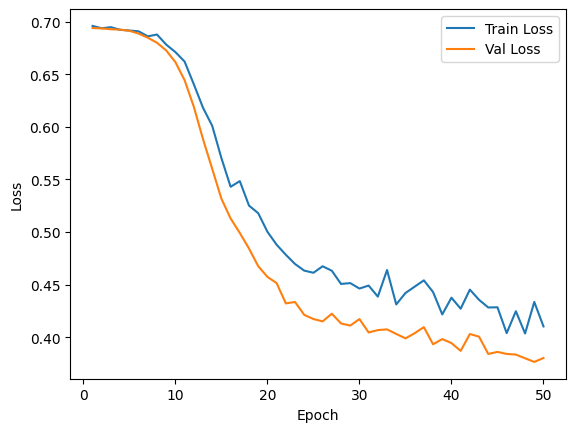

In [44]:
# Red neuronal
x_fi_train, x_fi_val, y_fi_train, y_fi_val = train_test_split(x_fi, y_fi, train_size=0.8, stratify=y_fi, random_state=42)
train_fi_loader, val_fi_loader = create_dataloaders(x_fi_train.values, y_fi_train.values,
 x_fi_val.values, y_fi_val.values)

ff_fi = NeuralNetwork(in_features = x_fi_train.shape[1])
fi_train_loss, fi_val_loss = simple_binary_train(ff_fi, train_fi_loader, val_fi_loader)
train_plot(fi_train_loss, fi_val_loss)


In [45]:
fi_pred_test = predict_from_dict(x_test[most_important], fi_estimators)
fi_pred_test['Red FF'] = ff_fi.predict(torch.tensor(x_test[most_important].values, dtype=torch.float32))

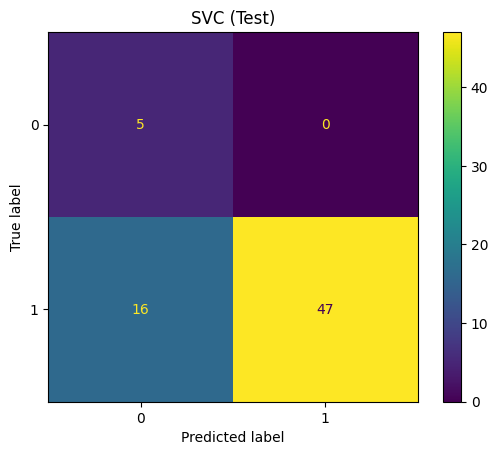

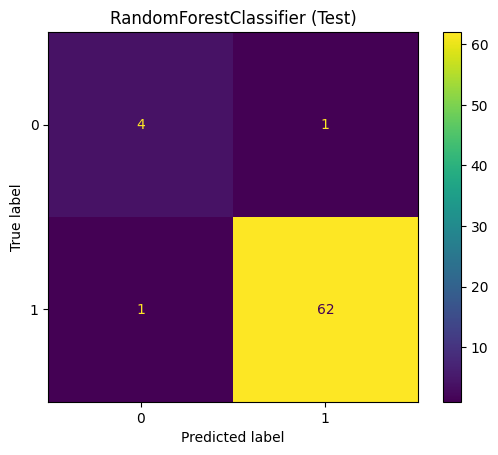

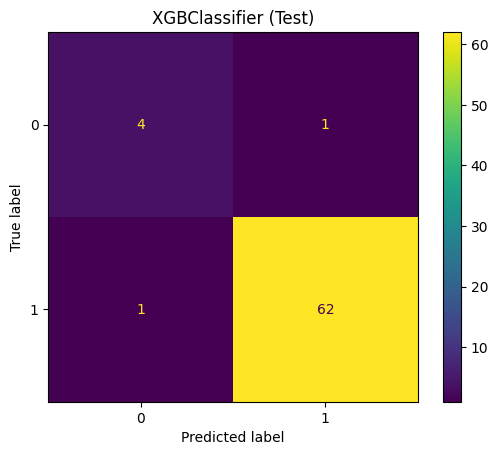

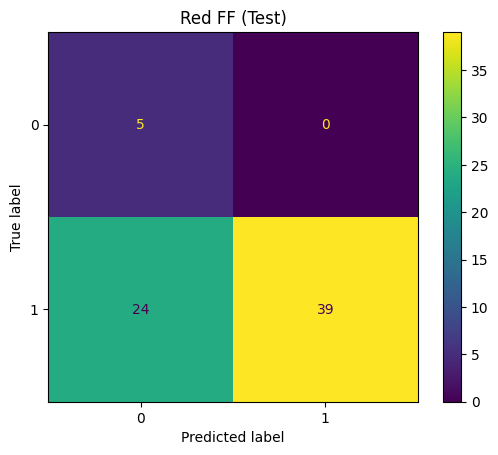

In [46]:
for estim in fi_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, fi_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

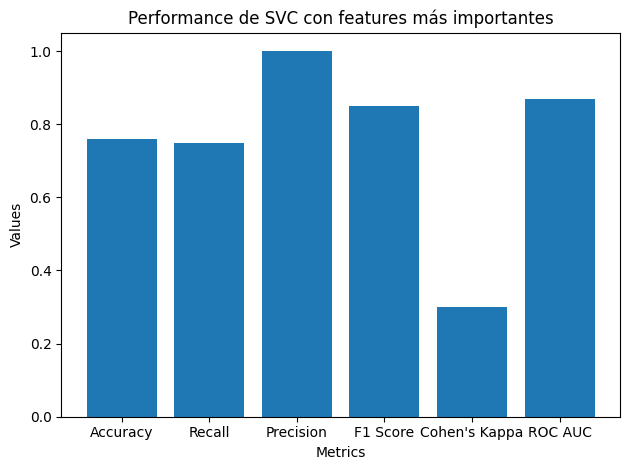

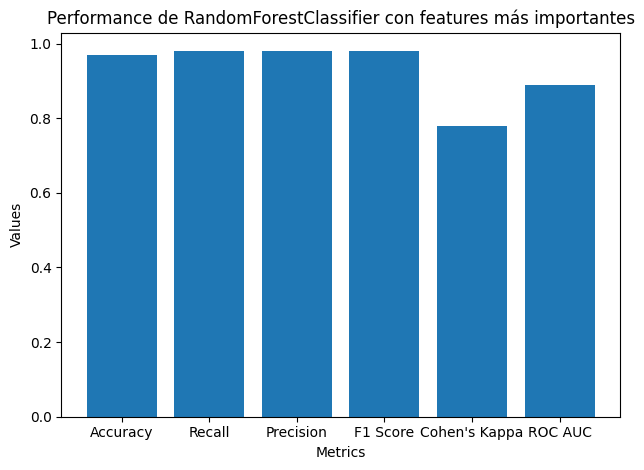

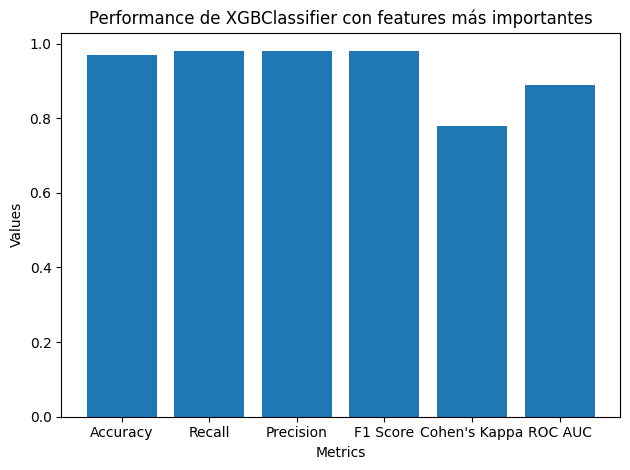

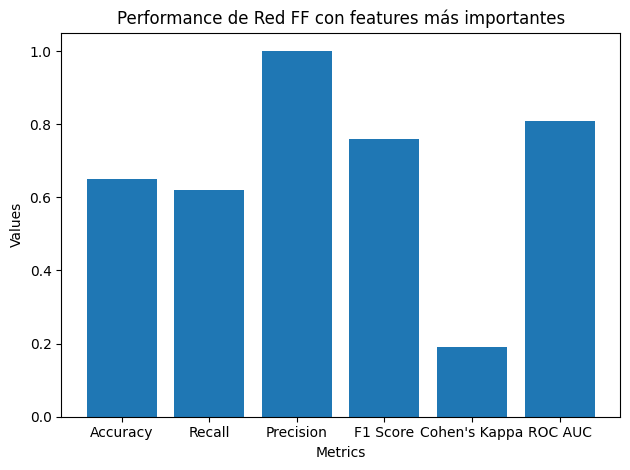

In [47]:
for estim in fi_pred_test:
    bar_metrics(y_test, fi_pred_test[estim], f"Performance de {estim} con features más importantes")